In [8]:
# ==============================================================
# Decision Tree Classification (DTC) Experiment
# ==============================================================
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import prepare_data

# Experiment config
random_state = 42
results = []
partial_save_path = "results/dtc_partial_results.csv"

In [2]:
# ---
# 1. Load Data
# ---
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print("Loaded train/test data.")

Loaded train/test data.


In [3]:
# ---
# 2. Prepare Data for TREE Models
# ---
# We MUST use mode="tree". This skips scaling and uses OrdinalEncoders.
# We fit ONCE on the training data.
print("Fitting encoders on train data...")
out_train_init = prepare_data(
    train_df,
    mode="tree",
    training=False,  # We only need the encoders
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = {}  # Scalers are not used
print("Fit complete.")

# Prepare TEST set using the *same* "tree" mode and fitted objects
print("Preparing test set...")
out_test = prepare_data(
    test_df,
    mode="tree",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

# Clean inf/-inf values
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for trees. Shape: {X_test.shape}")

Fitting encoders on train data...
Fit complete.
Preparing test set...
Test set prepared for trees. Shape: (555719, 13)


In [4]:
# ---
# 3. Define Experiment Parameters
# ---
# Test all relevant ratios
ratios_to_test = [None, 0.05, 0.1, 0.2, 0.5, 1.0]
# Test BOTH resample types
resample_types_to_test = ["df_up", "df_down"] 

# Test parameters for overfitting lesson
params_to_test = [
    {"name": "DTC_Gini_Full", "params": {"criterion": "gini", "max_depth": None}},
    {"name": "DTC_Entropy_Full", "params": {"criterion": "entropy", "max_depth": None}},
    {"name": "DTC_Gini_Depth_10", "params": {"criterion": "gini", "max_depth": 10}},
]

In [5]:
# ---
# 4. Run Experiment Loop
# ---
print("\nStarting Decision Tree experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    # Prepare training data for this *specific ratio*
    # We use fit=False (THE CORRECT WAY)
    out_train = prepare_data(
        train_df,
        mode="tree",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    # *** CORRECTED: Loop over resample types ***
    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        # Clean inf/-inf values
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        for p_info in params_to_test:
            model_name = p_info["name"]
            params = p_info["params"]
            start_k_time = time.time()

            print(f"    ⏳ Running {model_name} ...", end="")
            sys.stdout.flush()

            model = DecisionTreeClassifier(random_state=random_state, **params)
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Metrics
            f1 = f1_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_prob)
            prec = precision_score(y_test, y_pred, zero_division=0)
            acc = accuracy_score(y_test, y_pred)
            
            results.append(
                {
                    "model": model_name,
                    "ratio": ratio,
                    "resample_type": resample_type.replace("df_",""),
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                    "roc_auc": auc,
                }
            )

            print(
                f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} | Time={time.time() - start_k_time:.1f}s"
            )
            sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting Decision Tree experiment loop...

[20:03:52] Starting ratio 1/6 → ratio=None
  [20:03:55] → Training on df_up (samples=1,296,675)
    ⏳ Running DTC_Gini_Full ... done → F1=0.7632, Recall=0.7977, AUC=0.8983 | Time=9.8s
    ⏳ Running DTC_Entropy_Full ... done → F1=0.7679, Recall=0.7958, AUC=0.8974 | Time=9.6s
    ⏳ Running DTC_Gini_Depth_10 ... done → F1=0.8347, Recall=0.7795, AUC=0.9851 | Time=8.3s
  [20:04:22] → Training on df_down (samples=1,296,675)
    ⏳ Running DTC_Gini_Full ... done → F1=0.7632, Recall=0.7977, AUC=0.8983 | Time=8.5s
    ⏳ Running DTC_Entropy_Full ... done → F1=0.7679, Recall=0.7958, AUC=0.8974 | Time=7.8s
    ⏳ Running DTC_Gini_Depth_10 ... done → F1=0.8347, Recall=0.7795, AUC=0.9851 | Time=8.0s
  💾 Saved intermediate results → results/dtc_partial_results.csv
  ✅ Completed ratio=None in 0.9 min

[20:04:47] Starting ratio 2/6 → ratio=0.05
  [20:04:50] → Training on df_up (samples=1,353,627)
    ⏳ Running DTC_Gini_Full ... done → F1=0.7581, Recall=0.7823, 

In [6]:
# ---
# 5. Show Final Results
# ---
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing Decision Tree Models ---")
print(results_df.head(10))

results_df.to_csv("results/dtc_results.csv", index=False)
print("\nSaved final results to results/dtc_results.csv")


All ratios completed.
Total experiments logged: 36

--- Top Performing Decision Tree Models ---
                model  ratio resample_type  accuracy  precision    recall  \
2   DTC_Gini_Depth_10    NaN            up  0.998809   0.898442  0.779487   
5   DTC_Gini_Depth_10    NaN          down  0.998809   0.898442  0.779487   
24      DTC_Gini_Full   0.50            up  0.998355   0.788021  0.785082   
31   DTC_Entropy_Full   1.00            up  0.998323   0.777574  0.792075   
25   DTC_Entropy_Full   0.50            up  0.998317   0.776761  0.791608   
18      DTC_Gini_Full   0.20            up  0.998328   0.781742  0.786480   
7    DTC_Entropy_Full   0.05            up  0.998301   0.770130  0.798135   
30      DTC_Gini_Full   1.00            up  0.998334   0.785748  0.781352   
12      DTC_Gini_Full   0.10            up  0.998285   0.770417  0.791608   
13   DTC_Entropy_Full   0.10            up  0.998273   0.769196  0.789277   

          f1   roc_auc  
2   0.834748  0.985082  
5   0


Generating plots...


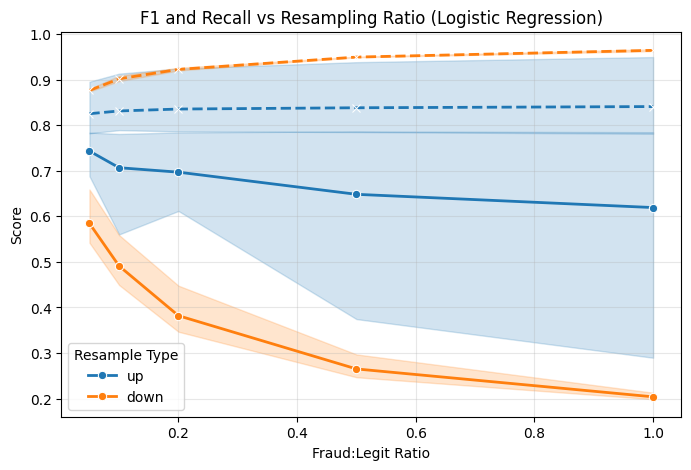

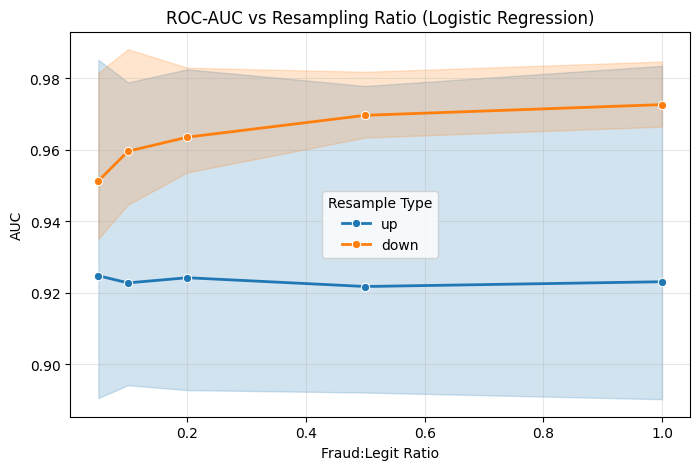

Plots saved to /results directory.


In [13]:
# ---
# 6. Plot Results
# ---

# ---- Plot F1 & Recall vs Ratio ----
print("\nGenerating plots...")
plt.figure(figsize=(8,5))

# Plot F1
sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type",
             marker="o", linewidth=2, legend="brief")

# Plot Recall on same chart
sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type",
             marker="x", linestyle="--", linewidth=2, legend=False)

plt.title("F1 and Recall vs Resampling Ratio (Logistic Regression)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.savefig("results/logreg_f1_recall_plot.png")
plt.show()

# ---- Plot ROC-AUC vs Ratio ----
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="roc_auc", hue="resample_type",
             marker="o", linewidth=2)
plt.title("ROC-AUC vs Resampling Ratio (Logistic Regression)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("AUC")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.savefig("results/logreg_auc_plot.png")
plt.show()

print("Plots saved to /results directory.")